
 <body>
  <h1>Objective of the project</h1>
    <p style='font-size:15px'>The train data (train_v2.csv) contains user transactions from August 1st 2016 to April 30th 2018.
The test data (test_v2.csv) contains user transactions from May 1st 2018 to October 15th 2018.</p>
  <p style='font-size:15px'>Our goal is to predict users' trasactions during the period 2018.12 - 2019.1 given 
the test data(test_v2.csv).</p>
    <p style='font-size:15px'>To see the more detailed data descriptions and evaluation creterion etc, please visit the site,
https://www.kaggle.com/c/ga-customer-revenue-prediction</p>
</body>



 <body>
  <h1>Stretegy</h1>
    <p style='font-size:15px'>Our strategy is to set the data from May 1st 2017 to October 31st 2017 as the 
training set and extract target variable from the data of period, December 1st 2017 to January 31st 2018.</p>
  <p style='font-size:15px'>A few important steps are the followings:</p>
    <p style='font-size:15px'>1. We first explore how the given data set looks like. We will see most columns are categorical columns in which some of the have thousands of unique values. Also, in this stage, we simply clean data for furture use. For instance, we drop columns with constant values which are not useful for our training stage.</p>
    <p style='font-size:15px'>2. Since many categorical columns have numerous unique values, we can not simply apply one-hot encoding for those columns. Thus, we will perform Principal Component Analysis (PCA) in the later stage. To do so, we investigate how each categorical columns are related to the amount of transactions so that we determine the dimension in the PCA part. </p>
    <p style='font-size:15px'>3. Based on the observations in the previous stage, we perform feature engineering such as PCA, one-hot encoding, normalization etc.</p>
    <p style='font-size:15px'>4. While we are asked to predict each visitor's future trasaction amount, the given data set consists of individual visit log information.Therefore, we rearrange data with respect to visitor IDs.</p>
    <p style='font-size:15px'>5. Finally, we perform training using Long-Short Term Memory(LSTM) with each visitors' visit history.</p>
</body>





In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import time
from datetime import datetime
from pandas import json_normalize
#from pandas.io.json import json_normalize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from zipfile import ZipFile
gc.enable()

import plotly.io as pio
pio.renderers.default = "svg"
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/username/input/train_v2.csv.zip'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
'''
-------------In the data loading process, we only choose data from May 1st 2017 to January 31st 2018---------
'''


def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['geoNetwork','device','totals','trafficSource']
    JSON_ARR_COL = ['customDimensions']
    zf = ZipFile(csv_path)
    frames = [tf[(20180201 > tf['date']) & (tf['date'] >= 20170501)] for tf in pd.read_csv(zf.open('train_v2.csv'),
                                       converters={column: json.loads for column in JSON_COLUMNS},
                                       dtype={'fullVisitorId': 'str'}, # Important!!
                                       chunksize = 50000)]
    
    df = pd.concat(frames,ignore_index=True)
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    return df

In [4]:
X_train = load_df('/Users/hyunkyujun/train_v2.csv.zip')


In [5]:
'''
--------------------There are 748307 rows--------------------
'''

X_train.shape 

(748307, 59)

In [6]:
pd.set_option('display.max_columns', 5000)

In [7]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748307 entries, 0 to 748306
Data columns (total 59 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    748307 non-null  object
 1   customDimensions                                   748307 non-null  object
 2   date                                               748307 non-null  int64 
 3   fullVisitorId                                      748307 non-null  object
 4   hits                                               748307 non-null  object
 5   socialEngagementType                               748307 non-null  object
 6   visitId                                            748307 non-null  int64 
 7   visitNumber                                        748307 non-null  int64 
 8   visitStartTime                                     748307 non-null  int64 
 9   geoN

In [8]:
X_train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,Firefox,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,1,1,1,1,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,water bottle,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,1,2,2,NaN,NaN,2,28,NaN,NaN,NaN,(not set),sites.google.com,referral,NaN,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo datas

 <body>
  <h1>Initial Observation</h1>
    <p style='font-size:15px'>As we can see, most columns are categorical columns.  Also, below we observe that many categorical columns have thousands' unique values</p>
  <p style='font-size:15px'>Thus, we conclude that we can not simply apply one-hot encoding for those categorical columns which will lead to enomous size of dimension. Thus, we will use PCA for feature engineering. To do so, we need to investigate how each categorical columns are related to the amount of transactions so that we determine the dimension in the PCA part.</p>
</body>



In [9]:
for c in X_train.columns:
    print('Column Name:' + c, 'Number of Unique Value:'+ str(X_train[c].nunique()))

Column Name:channelGrouping Number of Unique Value:8
Column Name:customDimensions Number of Unique Value:6
Column Name:date Number of Unique Value:276
Column Name:fullVisitorId Number of Unique Value:575250
Column Name:hits Number of Unique Value:600973
Column Name:socialEngagementType Number of Unique Value:1
Column Name:visitId Number of Unique Value:725680
Column Name:visitNumber Number of Unique Value:428
Column Name:visitStartTime Number of Unique Value:726469
Column Name:geoNetwork.continent Number of Unique Value:6
Column Name:geoNetwork.subContinent Number of Unique Value:23
Column Name:geoNetwork.country Number of Unique Value:220
Column Name:geoNetwork.region Number of Unique Value:341
Column Name:geoNetwork.metro Number of Unique Value:100
Column Name:geoNetwork.city Number of Unique Value:643
Column Name:geoNetwork.cityId Number of Unique Value:1
Column Name:geoNetwork.networkDomain Number of Unique Value:24923
Column Name:geoNetwork.latitude Number of Unique Value:1
Column

In [10]:
df = X_train.copy()

In [11]:
'''
--------------------Data Type change--------------------

Change the type of columns 'totals.transactions', 'totals.transactionRevenue' and 
'totals.totalTransactionRevenue' as float and replace the empty value with '0'.
'''

transaction_col = ['totals.transactions','totals.transactionRevenue' ,'totals.totalTransactionRevenue']
for c in transaction_col:
    df[c] = df[c].astype(float)
    df[c] = df[c].fillna(0)

In [12]:
'''
--------------------Visit date type--------------------
During the training, we will utilize the timing of each visits monthly-wise. 
For instance, for a visit of 23rd, September 2017, the 'date_' will be '20170901'
'''

import datetime
df['date_'] = df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]),1))
cnt_srs = df.groupby('date_')['date_'].agg(['count'])
cnt_srs.columns = ["count"]
x = range(cnt_srs.shape[0])


In [13]:
'''
As we mentioned earlier, we use customers' log data 
from May 1st 2017 to October 31st 2017 as the training set
'''

train = df.loc[df['date'] < 20171101]

In [14]:
'''
--------------------Columns with constant values--------------------
The columns with constant value will be dropped to save some memory and time in our modeling process.
'''

train = train.drop(['hits','customDimensions'],axis=1)
train = train.drop([c for c in train.columns if train[c].nunique(dropna=False)==1], axis=1)
train = train.drop([c for c in train.columns if train[c].nunique(dropna=False)==0], axis=1)

In [15]:
import plotly
import plotly.subplots
import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go



In [16]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        )
    return trace




    
 <body>
  <h1>Traffic Source Information</h1>
  <p style='font-size:15px'>Here, we explore how traffic sources are related to average transactions for each visit.
Throughout this observation, we'd like to determine proper number of dimension of traffic source
columns during Principle Component Analysis (PCA) process.</p>
    <p style='font-size:15px'>The second column of the follwing graph chart indicates avaerage trasaction for each category.</p>
</body>


In [55]:
traffic_source = ['trafficSource.campaign', 'trafficSource.source',
       'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.referralPath', 'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.isTrueDirect']

i = 1
traffic_source_dict = {}
for c in traffic_source:
    cnt_srs = train.groupby(c)['totals.transactionRevenue'].agg(['size', 'mean'])
    cnt_srs.columns = ["count", "mean"]
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    traffic_source_dict[(i,1)] = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
    traffic_source_dict[(i,2)] = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')
    i += 1

In [59]:
import plotly.io as pio
pio.renderers.default = "svg"

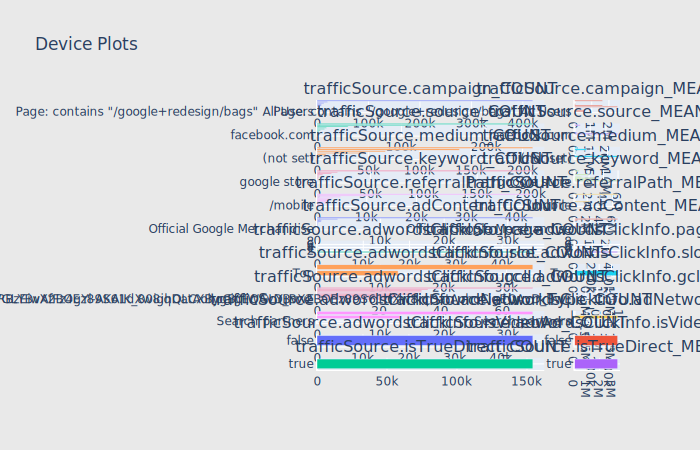

In [74]:
subplot_titles =[]
for c in traffic_source:
    subplot_titles.append(c+'_COUNT')
    subplot_titles.append(c+'_MEAN')
    
fig = plotly.subplots.make_subplots(rows=len(traffic_source), cols=2,
                                    subplot_titles=subplot_titles,column_widths=[100,20],row_heights=[10,10,10,10,
                                                                                                     10,10,
                                                                                                     10,10,
                                                                                                     10,10,
                                                                                                     10,10])
for i in range(len(traffic_source)):
    fig.append_trace(traffic_source_dict[(i+1,1)], i+1, 1)
    fig.append_trace(traffic_source_dict[(i+1,2)], i+1, 2)
fig['layout'].update(height=5000, width=2000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

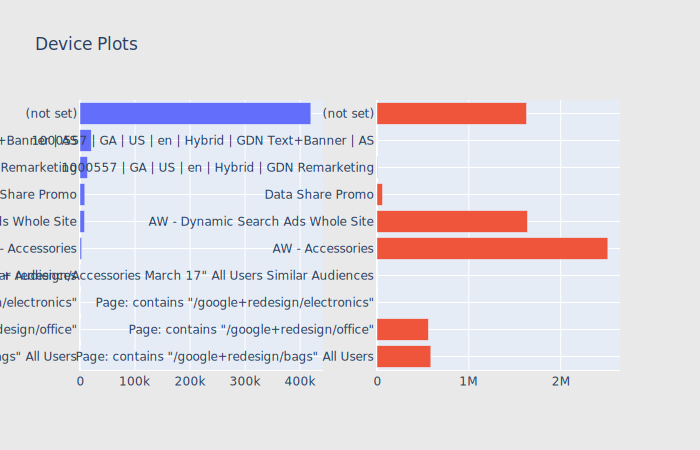

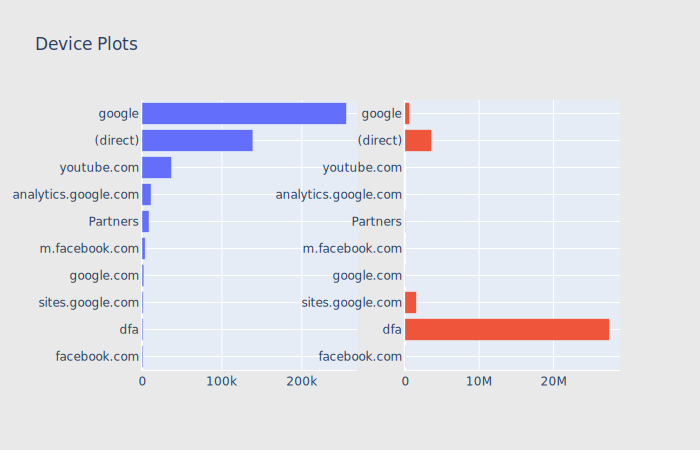

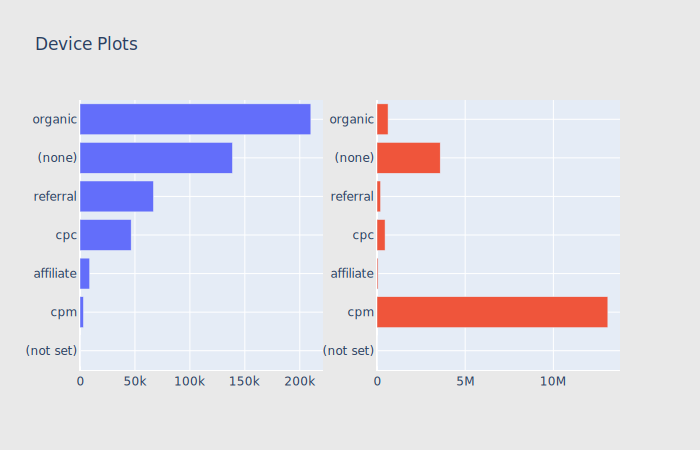

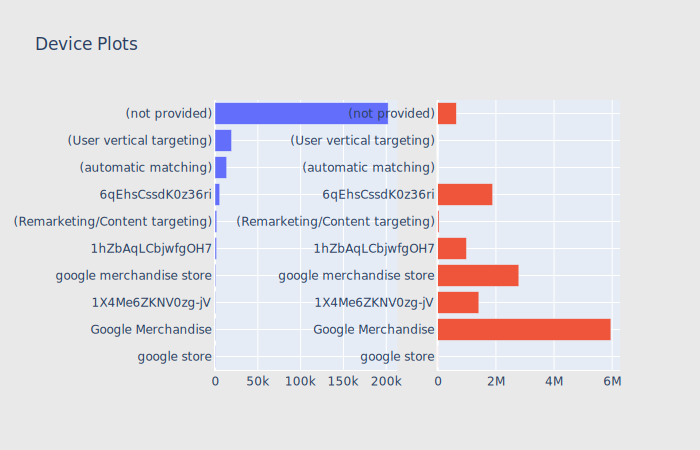

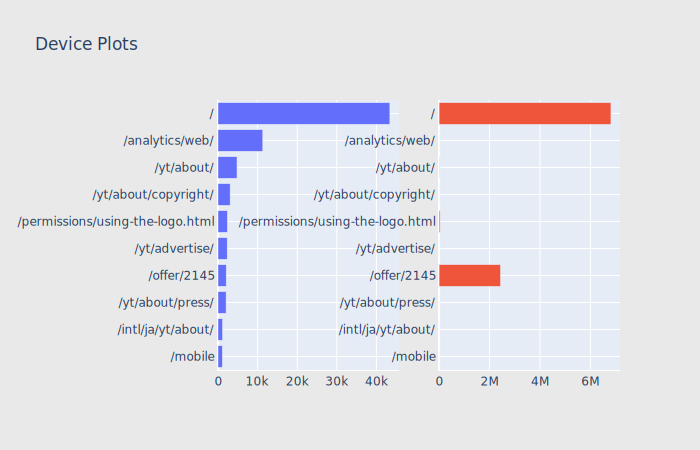

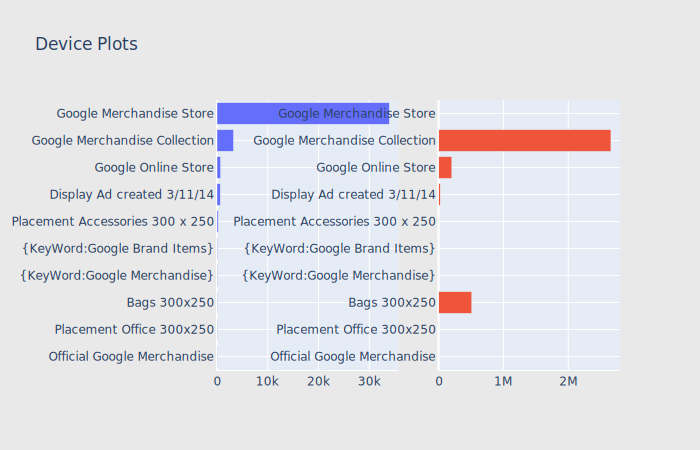

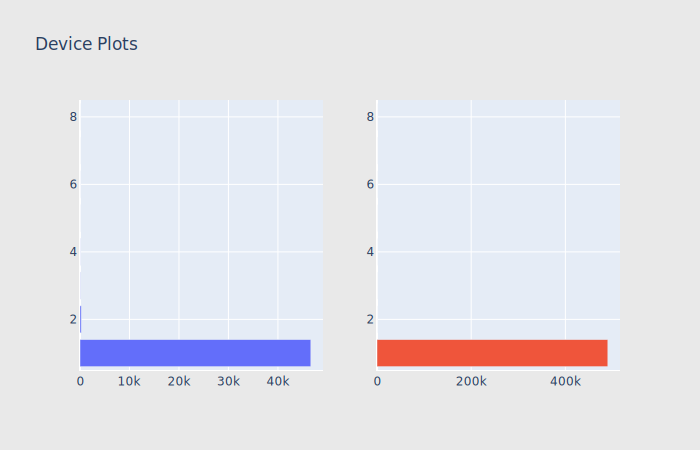

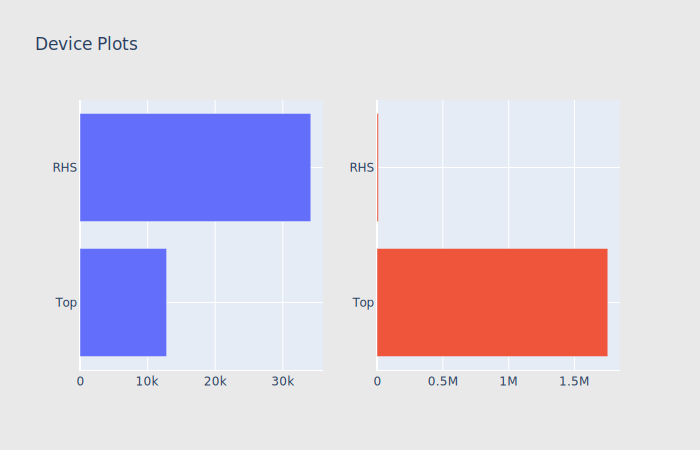

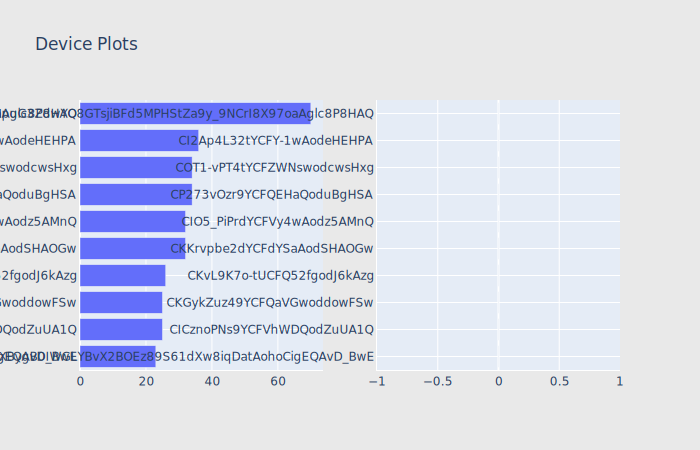

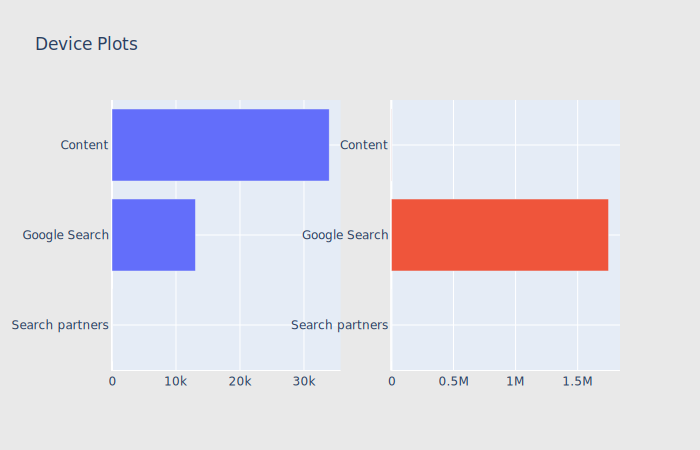

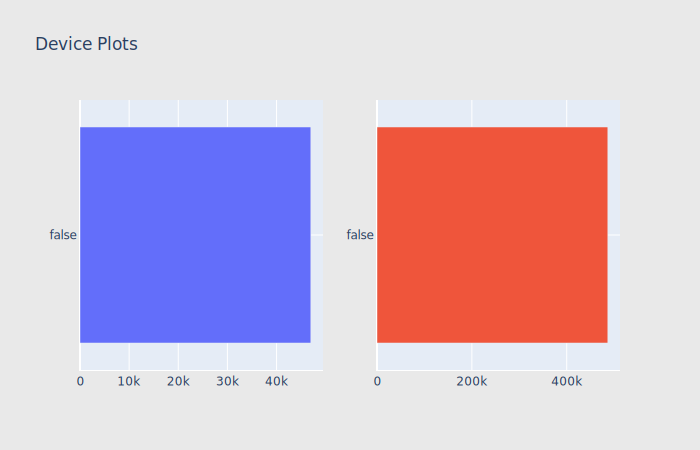

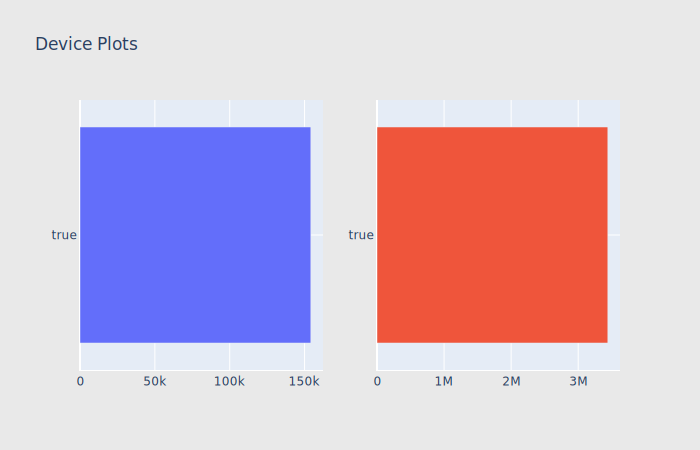

In [78]:
subplot_titles =[]
for c in traffic_source:
    subplot_titles.append(c+'_COUNT')
    subplot_titles.append(c+'_MEAN')
    

for i in range(len(traffic_source)):
    fig = plotly.subplots.make_subplots(rows=1, cols=2)
    fig.append_trace(traffic_source_dict[(i+1,1)], 1, 1)
    fig.append_trace(traffic_source_dict[(i+1,2)], 1, 2)
    fig['layout'].update(height=2000, width=2000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
    py.iplot(fig, filename='device-plots')

    
 <body>
  <h1>trafficSource Observation</h1>
  <p style='font-size:15px'>Above, we observe that in many cases, there are fair amount of relationships between traffic sources and 
transactions.
      For instance, in trafficSource.source column, '(direct)' source shows higer trasaction
while the count of the '(direct)' source is fairly large. </p>
<p style='font-size:15px'>In most cases, 10 largest sources in terms of count explain most of total counts.
This implies that maximum dimension of PCA for the most traffic source columns will be 10.</p>
</body>

In [208]:
for c in traffic_source:
    print(c, 'number of unique:'+ str(train[c].nunique()), 'number of null:' +str(train[c].isnull().sum()/train.shape[0]))

trafficSource.campaign number of unique:21 number of null:0.0
trafficSource.source number of unique:146 number of null:0.0
trafficSource.medium number of unique:7 number of null:0.0
trafficSource.keyword number of unique:884 number of null:0.5329295116916517
trafficSource.referralPath number of unique:798 number of null:0.757436296572028
trafficSource.adContent number of unique:47 number of null:0.9405231633447261
trafficSource.adwordsClickInfo.page number of unique:4 number of null:0.928733376197083
trafficSource.adwordsClickInfo.slot number of unique:2 number of null:0.928733376197083
trafficSource.adwordsClickInfo.gclId number of unique:9638 number of null:0.9286995363947075
trafficSource.adwordsClickInfo.adNetworkType number of unique:2 number of null:0.928733376197083
trafficSource.adwordsClickInfo.isVideoAd number of unique:1 number of null:0.928733376197083
trafficSource.isTrueDirect number of unique:1 number of null:0.6710094413048627


In [62]:
'''
--------------------dimension to use for PCA--------------------

'''


pca_dim_traffic = {'trafficSource.campaign':6,'trafficSource.source': 4, 'trafficSource.medium': 5,
                  'trafficSource.adContent':2,
                  'trafficSource.adwordsClickInfo.page':2, 'trafficSource.adwordsClickInfo.slot':3,
                   'trafficSource.adwordsClickInfo.adNetworkType':3,
                  'trafficSource.adwordsClickInfo.isVideoAd':2, 'trafficSource.isTrueDirect':2
                  }


    
 <body>
  <h1>Geographic Network Information</h1>
  <p style='font-size:15px'>Here, we explore how Geographic Networks are related to average transactions for each visit.
Throughout this observation, we'd like to determine proper number of dimension of geoNetwork
columns during Principle Component Analysis (PCA) algorithm.</p>
    <p style='font-size:15px'>The second column of the follwing graph chart indicates avaerage trasaction for each category.</p>
</body>

In [63]:
geoNetwork = ['geoNetwork.continent', 'geoNetwork.subContinent',
       'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro',
       'geoNetwork.city', 'geoNetwork.networkDomain']


i = 1
geoNetwork_dict = {}
for c in geoNetwork:
    cnt_srs = train.groupby(c)['totals.transactionRevenue'].agg(['size', 'mean'])
    cnt_srs.columns = ["count", "mean"]
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    geoNetwork_dict[(i,1)] = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
    geoNetwork_dict[(i,2)] = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')
    i += 1


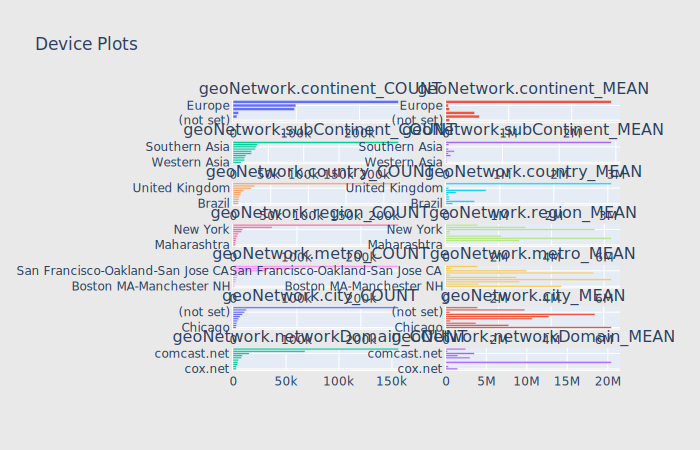

In [66]:
subplot_titles =[]
for c in geoNetwork:
    subplot_titles.append(c+'_COUNT')
    subplot_titles.append(c+'_MEAN')

fig = plotly.subplots.make_subplots(rows=len(geoNetwork), cols=2,subplot_titles=subplot_titles)
for i in range(len(geoNetwork)):
    fig.append_trace(geoNetwork_dict[(i+1,1)], i+1, 1)
    fig.append_trace(geoNetwork_dict[(i+1,2)], i+1, 2)
fig['layout'].update(height=5000, width=1000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')


 <body>
    <h1>GeoNetwork Observation</h1>
  <p style="font-size:15px">We observe that Geographic Network information provides very meaningful implications for the
trasactions. For example, geoNetwork.continent column show that transactions are signficantly higher
      in Americas in comparison with Europe and Asia. </p>
   <p style="font-size:15px">Also, the count of Americas is nearly half of total count.
We dicide that we perform just one-hot encoding for geoNetwork.continent column instead of PCA.
This is due to the fact that the number of unique value is manageble, 6, and each category has
siginificant implication on transactions amount. </p>
<p style="font-size:15px"> For other gegraphic network columns, we perform the PCA</p>
</body>

In [15]:
'''
--------------------dimension to use for PCA--------------------

'''

pca_dim_geoNetwork = {'geoNetwork.continent': 6,'geoNetwork.subContinent': 10, 'geoNetwork.country':10,
                     'geoNetwork.region':10, 'geoNetwork.metro':10
                     } 

In [214]:
for c in geoNetwork:
    print(c, 'number of unique:'+ str(train[c].nunique()), 'number of null:' +str(train[c].isnull().sum()/train.shape[0]))

geoNetwork.continent number of unique:6 number of null:0.0
geoNetwork.subContinent number of unique:23 number of null:0.0
geoNetwork.country number of unique:202 number of null:0.0
geoNetwork.region number of unique:281 number of null:0.0
geoNetwork.metro number of unique:91 number of null:0.0
geoNetwork.city number of unique:523 number of null:0.0
geoNetwork.networkDomain number of unique:9986 number of null:0.0


 <body>
  <h1>Device Information</h1>
  <p style='font-size:15px'>Here, we explore how devices used are related to average transactions for each visit.
Throughout this observation, we'd like to determine proper number of dimension of device
columns during Principle Component Analysis (PCA) algorithm.</p>
    <p style='font-size:15px'>The second column of the follwing graph chart indicates avaerage trasaction for each category.</p>
</body>

In [215]:
device = ['device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory']
    
i = 1
device_dict = {}
for c in device:
    cnt_srs = train.groupby(c)['totals.transactionRevenue'].agg(['size', 'mean'])
    cnt_srs.columns = ["count", "mean"]
    cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
    device_dict[(i,1)] = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
    device_dict[(i,2)] = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')
    i += 1
    

In [ ]:
subplot_titles =[]
for c in device:
    subplot_titles.append(c+'_COUNT')
    subplot_titles.append(c+'_MEAN')

fig = plotly.subplots.make_subplots(rows=len(device), cols=2,subplot_titles=subplot_titles)
for i in range(len(device)):
    fig.append_trace(device_dict[(i+1,1)], i+1, 1)
    fig.append_trace(device_dict[(i+1,2)], i+1, 2)
fig['layout'].update(height=1200, width=1000, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

 <body>
    <h1>Device Observation</h1>
  <p style="font-size:15px">We observe that device information provides very meaningful implications for the
trasactions. For example, device.Browser column show that transactions are signficantly higher
in Chrome in comparison with Internet Expolrer and Safari.</p>
   <p style="font-size:15px">For the columns with a few unique values, we just perform one-hot encoding and do the PCA for other
columns </p>

</body>

In [16]:
'''
--------------------dimension to use for PCA--------------------

'''

pca_dim_device = {'device.browser':8, 'device.operatingSystem':8,
                 'device.isMobile':2, 'device.deviceCategory':3} 

In [218]:
for c in device:
    print(c, 'number of unique:'+ str(train[c].nunique()), 'number of null:' +str(train[c].isnull().sum()/train.shape[0]))

device.browser number of unique:38 number of null:0.0
device.operatingSystem number of unique:18 number of null:0.0
device.isMobile number of unique:2 number of null:0.0
device.deviceCategory number of unique:3 number of null:0.0


 <body>
  <h1>Principal Component Analysis</h1>
  <p style='font-size:15px'>1. we first apply one-hot encoding for categorical columns </p>
    <p style='font-size:15px'>2. then, normalize the one-hot encoded columns</p>
    <p style='font-size:15px'>3. finally excute the dimension reduction process.</p>
</body>


In [17]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler


def one_hot_pca(df,column_name,dummy_na,n_comp = None):
    # return Numpy array
    y = pd.get_dummies(df[column_name], prefix=column_name[:5],dummy_na=dummy_na)
    sc = StandardScaler()
    y = pd.DataFrame(sc.fit_transform(y),columns = y.columns,index=y.index)
    if n_comp:
        pca = PCA(n_components = n_comp)
    else:
        pca = PCA(n_components = 'mle')
    y = pd.DataFrame(pca.fit_transform(y), index=y.index,columns=[column_name + str(i) for i in range(n_comp)])
    return y
    
    

In [18]:
def one_hot_pca_batch(df,column_name, dummy_na, batch_size,n_comp = None):
    # return Numpy array
    y = pd.get_dummies(df[column_name], prefix=column_name[:5],dummy_na=dummy_na)
    sc = StandardScaler()
    y = pd.DataFrame(sc.fit_transform(y),columns = y.columns,index=y.index)
    if n_comp:
        n_bachtes = batch_size
        inc_pca = IncrementalPCA(n_components = n_comp)
        for x_batch in np.array_split(y,n_bachtes):
            inc_pca.partial_fit(x_batch)
    else:
        pca = PCA(n_components = 'mle')
    y = pd.DataFrame(inc_pca.transform(y), index=y.index,columns=[column_name + str(i) for i in range(n_comp)])
    return y

 <body>
  <h1>One_hot encoding</h1>
  <p style='font-size:15px'>Rememeber that there are some categorical columns in which we would just perform 
one_hot encoding instead of PCA </p>
    <p style='font-size:15px'> To do one_hot encoding  </p>
    <p style='font-size:15px'>
1. we first apply one-hot encoding for categorical columns </p>
    <p style='font-size:15px'>2. then, normalize the one-hot encoded columns</p>
</body>

In [19]:
def one_hot(df,column_name,dummy_na):
    # return Numpy array
    y = pd.get_dummies(df[column_name], prefix=column_name[:5],dummy_na=dummy_na)
    sc = StandardScaler()
    y = pd.DataFrame(sc.fit_transform(y),columns = y.columns,index=y.index)
    return y
    

 <body>
  <h1>Normalization</h1>
  <p style='font-size:15px'>For the numerical columns we perform standard scalar normilization,i.e.,  </p>
    <p style='font-size:15px'> 1. subtract mean </p>
    <p style='font-size:15px'>2. and divide by standard deviation.</p>
</body>

In [20]:
def scale(df,column_name):
    # return Numpy array
    #df[column_name] = df[column_name].astype(float)
    sc = StandardScaler()
    df[column_name] = sc.fit_transform(sc.fit_transform(df[[column_name]]))
    

In [21]:

'''
-----------Perform one_hot encoding, PCA and normalization for device columns------------------
'''


for k,v in pca_dim_device.items():
    y = one_hot_pca(train,k,True,v)
    train = train.drop(k,axis=1)
    train = train.join(y)

In [22]:

'''
-----------Perform one_hot encoding, PCA and normalization for geoNetwork columns------------------
'''

for k,v in pca_dim_geoNetwork.items():
    y = one_hot_pca(train,k,True,v)
    train = train.drop(k,axis=1)
    train = train.join(y)

In [23]:

'''
-----------Perform one_hot encoding, PCA and normalization for traffic source columns------------------
'''

for k,v in pca_dim_traffic.items():
    y = one_hot_pca(train,k,True,v)
    train = train.drop(k,axis=1)
    train = train.join(y)

In [24]:
train = train.drop(['trafficSource.referralPath','trafficSource.keyword',
                    'trafficSource.adwordsClickInfo.gclId',
                   'geoNetwork.city','geoNetwork.networkDomain',
                   'visitStartTime','visitId',
                   'date'],axis=1)

In [25]:
'''
-----------Perform one_hot encoding for the channel Grouping columns------------------
'''

to_be_one_hot = ['channelGrouping','date_']

for c in to_be_one_hot:
    y = one_hot(train,c,train[c].isnull().sum() > 1)
    train = train.drop(c,axis=1)
    train = train.join(y)

In [26]:
'''
-----------totals columns have numerical values. Change type to float and fill empty values------------------
'''



train['totals.newVisits'] = train['totals.newVisits'].astype(float)
train['totals.newVisits'].fillna(0, inplace=True)
train['totals.timeOnSite'] = train['totals.timeOnSite'].astype(float)
train['totals.timeOnSite'].fillna(train['totals.timeOnSite'].mean(), inplace=True)
train['totals.bounces'] = train['totals.bounces'].astype(float)
train['totals.bounces'].fillna(0, inplace=True)
train['totals.hits'] = train['totals.hits'].astype(float)
train['totals.pageviews'] = train['totals.pageviews'].astype(float)
train['totals.pageviews'].fillna(0, inplace=True)
train = train.drop(['totals.sessionQualityDim'],axis=1)


In [32]:
'''
-----------------------Normalize numerical values------------------------------
'''

to_be_scaled = ['visitNumber','totals.hits','totals.pageviews','totals.timeOnSite',
                'totals.newVisits',
                'totals.transactions',
                'totals.transactionRevenue','totals.totalTransactionRevenue','totals.bounces']
for c in to_be_scaled:
    scale(train,c)

 <body>
  <h1>Summary after feature engineering (Normalization, PCA, One_hot econding etc)</h1>
</body>

In [33]:
train.head()

,fullVisitorId,visitNumber,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,device.browser0,device.browser1,device.browser2,device.browser3,device.browser4,device.browser5,device.browser6,device.browser7,device.operatingSystem0,device.operatingSystem1,device.operatingSystem2,device.operatingSystem3,device.operatingSystem4,device.operatingSystem5,device.operatingSystem6,device.operatingSystem7,device.isMobile0,device.isMobile1,device.deviceCategory0,device.deviceCategory1,device.deviceCategory2,geoNetwork.continent0,geoNetwork.continent1,geoNetwork.continent2,geoNetwork.continent3,geoNetwork.continent4,geoNetwork.continent5,geoNetwork.subContinent0,geoNetwork.subContinent1,geoNetwork.subContinent2,geoNetwork.subContinent3,geoNetwork.subContinent4,geoNetwork.subContinent5,geoNetwork.subContinent6,geoNetwork.subContinent7,geoNetwork.subContinent8,geoNetwork.subContinent9,geoNetwork.country0,geoNetwork.country1,geoNetwork.country2,geoNetwork.country3,geoNetwork.country4,geoNetwork.country5,geoNetwork.country6,geoNetwork.country7,geoNetwork.country8,geoNetwork.country9,geoNetwork.region0,geoNetwork.region1,geoNetwork.region2,geoNetwork.region3,geoNetwork.region4,geoNetwork.region5,geoNetwork.region6,geoNetwork.region7,geoNetwork.region8,geoNetwork.region9,geoNetwork.metro0,geoNetwork.metro1,geoNetwork.metro2,geoNetwork.metro3,geoNetwork.metro4,geoNetwork.metro5,geoNetwork.metro6,geoNetwork.metro7,geoNetwork.metro8,geoNetwork.metro9,trafficSource.campaign0,trafficSource.campaign1,trafficSource.campaign2,trafficSource.campaign3,trafficSource.campaign4,trafficSource.campaign5,trafficSource.source0,trafficSource.source1,trafficSource.source2,trafficSource.source3,trafficSource.medium0,trafficSource.medium1,trafficSource.medium2,trafficSource.medium3,trafficSource.medium4,trafficSource.adContent0,trafficSource.adContent1,trafficSource.adwordsClickInfo.page0,trafficSource.adwordsClickInfo.page1,trafficSource.adwordsClickInfo.slot0,trafficSource.adwordsClickInfo.slot1,trafficSource.adwordsClickInfo.slot2,trafficSource.adwordsClickInfo.adNetworkType0,trafficSource.adwordsClickInfo.adNetworkType1,trafficSource.adwordsClickInfo.adNetworkType2,trafficSource.adwordsClickInfo.isVideoAd0,trafficSource.adwordsClickInfo.isVideoAd1,trafficSource.isTrueDirect0,trafficSource.isTrueDirect1,chann_(Other),chann_Affiliates,chann_Direct,chann_Display,chann_Organic Search,chann_Paid Search,chann_Referral,chann_Social,date__2017-05-01,date__2017-06-01,date__2017-07-01,date__2017-08-01,date__2017-09-01,date__2017-10-01
0,3162355547410993243,-0.142970,-0.386621,-0.421954,0.935653,0.569154,8.692996e-18,-0.108285,-0.031169,-0.0231,1.819898,-2.927731,2.141954,0.683791,0.193770,-0.217127,-0.095390,0.391613,1.680658,-0.077053,-0.188761,-0.155850,-0.037446,-0.029716,-0.011847,-0.005134,-1.109615,9.210633e-27,-1.073211,-0.118148,4.479896e-13,1.489365,-1.718999,-0.335984,-0.059062,-0.032320,9.824930e-12,1.337288,0.372655,-2.351502,-2.426981,1.023501,-0.623860,0.005997,-0.058253,0.184349,-0.107863,1.279311,-0.369856,0.685697,-0.487179,-1.438397,0.041256,0.398508,-1.252007,-0.405638,-0.130949,-1.127455,-0.042214,0.000409,-0.00409,0.000088,0.001441,0.000232,0.000916,-0.000258,-0.000720,-1.125112,-0.094864,0.033667,0.005023,-0.011874,-0.004389,-0.001103,-0.002154,-0.000026,-0.003504,-0.498572,-0.00345,-0.002724,0.000687,-0.001603,0.00059,-1.175037,0.137448,-0.020991,0.002437,-1.361062,-0.326569,-0.079705,-0.054637,-0.020767,-0.425892,0.004821,-0.468835,-0.002795,-0.464067,-0.007767,3.113583e-10,-0.464018,-0.007659,-0.00008,-0.469012,9.265650e-14,-0.981890,1.528529e-13,-0.004108,-0.1374,-0.441296,-0.291465,1.023541,-0.177812,-0.373379,-0.331077,-0.39991,-0.393525,-0.422491,-0.466712,-0.474979,1.918604
1,8934116514970143966,0.454193,-0.268495,-0.258201,-1.068773,-1.756994,-7.459256e-01,-0.108285,-0.031169,-0.0231,-0.876392,0.056055,0.011706,0.002903,-0.000656,-0.00077

In [34]:
train.info(verbose=True,max_cols=5000)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474124 entries, 0 to 748306
Data columns (total 120 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   fullVisitorId                                  474124 non-null  object 
 1   visitNumber                                    474124 non-null  float64
 2   totals.hits                                    474124 non-null  float64
 3   totals.pageviews                               474124 non-null  float64
 4   totals.bounces                                 474124 non-null  float64
 5   totals.newVisits                               474124 non-null  float64
 6   totals.timeOnSite                              474124 non-null  float64
 7   totals.transactions                            474124 non-null  float64
 8   totals.transactionRevenue                      474124 non-null  float64
 9   totals.totalTransactionRevenue      

 <body>
  <h1>Rearrange Data with respect to full visitor ID</h1>
  <p style='font-size:15px'>Recall that our goal is to predict each consumers' future transactions.
Thus, one of the most important part of is to rearrange our data in terms of full visitor ID. </p>
    <p style='font-size:15px'> Here, we make Python dictionary where keys are full visitor IDs and values are lists of their
transactions log </p>
</body>

In [28]:
train_dict = train.groupby('fullVisitorId')[train.columns[1:]].apply(lambda g: g.values.tolist()).to_dict()


 <body>
  <h1>Make target varialbe for each visitor ID</h1>
  <p style='font-size:15px'>for each visitor ID, the target varialbe is the amount of transactions during 
the period December 2017 to January 2018 </p>
</body>

In [29]:
target = df.loc[(20171201 <= df['date'])  &(df['date'] < 20180201)]
target_dict = target.groupby('fullVisitorId')['totals.transactionRevenue'].apply(lambda g: g.values.sum()).to_dict()

 <body>
  <h1>Preprocess for the efficient training</h1>
  <p style='font-size:15px'>Before we perform actual training using LSTM, we preprocess data so that we utilize 
mini-batch size training. Using mini batch size siginificantly improves the time effieicny of the training.</p>
    <p style='font-size:15px'> To do so, we group visit log in terms of the number of the visits. 
Due to the technical constraint, we have to feed training sets which have the same number of 
time steps for each training session.   </p>
   
</body>

In [30]:
import math
from collections import defaultdict
train_dict2 = defaultdict(list)
target_dict_log = defaultdict(list)
for k,v in train_dict.items():
    temp = np.asarray(v)
    train_dict2[temp.shape[0]].append(temp)
    #target_dict_log[temp.shape[0]].append([target_dict[k]] if k in target_dict else [0.0]) 
    target_dict_log[temp.shape[0]].append([math.log(1+target_dict[k])] if k in target_dict else [0.0] )

In [31]:
'''
--------------- Change the Python array to Numpy array to feed these to Tensorflow training -----------------

'''

for k,v in train_dict2.items():
    train_dict2[k] = np.asarray(v)
for k,v in target_dict_log.items():
    target_dict_log[k] = np.asarray(v)

 <body>
  <h1>Build the LSTM model using Keras API</h1>
  <p style='font-size:15px'>BWe use stacked LSTM model.
For the optimizer, we use ADAM for fast optimization</p>

   
</body>

In [35]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras import optimizers


model = Sequential()

model.add(LSTM(250, return_sequences=True, input_shape=(None, 119)))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(20, return_sequences=False))
model.add(Dense(1, activation='linear'))
#model.add(TimeDistributed(Dense(1)))
print(model.summary(100))

model.compile(loss='mse',
              optimizer='adam')





Model: "sequential"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
lstm (LSTM)                                  (None, None, 250)                       370000         
____________________________________________________________________________________________________
lstm_1 (LSTM)                                (None, None, 100)                       140400         
____________________________________________________________________________________________________
lstm_2 (LSTM)                                (None, 20)                              9680           
____________________________________________________________________________________________________
dense (Dense)                                (None, 1)                               21             
Total params: 520,101
Trainable params: 520,101
Non-trainable params: 0

 <body>
  <h1>Training</h1>
  <p style='font-size:15px'>Feed preprocessed data to our LSTM model</p>

   
</body>

In [50]:
for j in range(5):
    for i in train_dict2:
        model.fit(train_dict2[i],target_dict_log[i], epochs=1, 
                  batch_size=max(256//(2**i),16),verbose=1)


125/125 [==============================] - 3s 20ms/step - loss: 1.8818


 <body>
  <h1>Save the trained model</h1>
  <p style='font-size:15px'>The saved model will be applied to test set later.</p>

   
</body>

In [52]:
model.save('google_revenue_range_1to6_5times_LSTM.h5')